# **Coursework for the AI Modeling Discipline**

This notebook aims to build and compare three machine learning models: ANN, Random Forest, and SVM, based on the dissertation "Development of predictive models for biomass gasification using artificial neural networks."

# **Libraries and Settings**

In [ ]:
# Installs the required libraries:
# - prince: for performing various matrix factorization techniques including PCA, CA, and MCA
# - imblearn: for handling imbalanced datasets (e.g., SMOTE)
# - smogn: for performing SMOGN (Synthetic Minority Over-sampling Technique for Regression)
# - scikit-learn: popular machine learning library (required for preprocessing, modeling, etc.)
!pip install prince imblearn smogn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import prince
import smogn

# **Data Preparation and Cleaning**

With the aim of feeding predictive models based on Artificial Neural Networks (ANNs), an extensive literature review was conducted on scientific articles related to biomass gasification, focusing on the construction of two robust and diverse datasets. The first dataset (Df1) was used for training and testing the model, while the second dataset (Df2) was reserved exclusively for validating the ANN's performance.

During the dataset assembly process, a wide range of relevant variables were extracted whenever available in the analyzed studies. These included: gasifier type, biomass type and elemental composition (C, H, O, N, and S), physicochemical properties (volatile matter - VM, moisture content - MC, ash, and fixed carbon - FC), operational parameters (equivalence ratio - ER, temperature, and steam-to-biomass ratio - S/B), product gas composition (H₂, CO, CO₂, CH₄, and N₂), and performance metrics such as gas yield (GY), cold gas efficiency (CGE), carbon conversion efficiency (CCE), and lower heating value (LHV). Part of the data was manually extracted from graphs using WebPlotDigitizer v4.5.

To ensure data quality and consistency, several filters were applied, which led to the exclusion of:

- Data derived from simulations (only experimental data was retained)

- Records without VM values or with VM equal to zero

- Cases with ER and S/B equal to zero

- Entries missing key output gas data (H₂, CO, CO₂, CH₄, and N₂)

- Records lacking temperature information

- Cases involving mineral coal, which was outside the study's scope

In addition, data standardization was performed to ensure consistency. Percentages of elemental composition (C, H, O, N, and S) and physical fractions (VM, MC, ash, and FC) were checked, excluding entries with totals exceeding 100%. Outliers were also removed based on statistical analysis (histograms) and comparisons with the literature, particularly with the ranges described by Vassilev (2010), a key reference in biomass characterization.

Examples of data excluded based on this analysis include:

- Carbon values above 70.9% (e.g., 77.55% and 79.34%)

- Hydrogen values below 3.2% (e.g., 2.36%)

- Nitrogen content between 6.13% and 6.81%, due to empty classes in histograms

- Moisture content above 18%, to avoid distortions in the dataset

- Extreme ash value (36.53%)

- Temperatures outside typical ranges (353–562 °C and 911–1050 °C)

- Outlier S/B value of 4.04

After the curation process, the final dataset consisted of 603 valid records, distributed as follows:

- Df1 (training/testing): 491 records (81.43% of total)

  - 80% for training: 393 records (65.17% of total)

  - 20% for testing: 98 records (16.25% of total)

- Df2 (validation): 112 records (18.57% of total)


The dataset used in this study was provided by the course instructor, Professor Brunno Ferreira dos Santos (who is also the dissertation co-supervisor). However, we did not receive the preprocessed version. After performing the preprocessing steps in Excel, our final dataset included 581 rows, not 603 as originally indicated.

# **Exploratory Data Analysis (EDA)**

###**Statistical Summary**

In [ ]:
# Read data from the Excel file located at /content/BD.xlsx
df =  pd.read_excel('/content/BD.xlsx', sheet_name='T')

In [ ]:
# Display the first five rows of the dataset (df)
# If the import was successful, all 14 variables are present with correct data types
df.head()

,C [%wt db],H [%wt db],O [%wt db],N [%wt db],Volatile matter (VM) [%],Moisture content (MC) [%wt],Ash [%wt],ER [-],T [ºC],Steam/ Biomass,CO [%vol],CO2 [%vol],CH4 [%vol],H2 [%vol]
0,46.4,5.7,47.7,0.2,81.3435,8.5,1.0065,0.32,750.0,0.0,33.607908,40.127089,8.166627,14.709343
1,46.4,5.7,47.7,0.2,81.3435,8.5,1.0065,0.36,776.5,0.0,29.044615,38.192880,7.593511,16.538982
2,46.4,5.7,47.7,0.2,81.3435,8.5,1.0065,0.38,790.5,0.0,29.645814,37.396504,7.980681,19.158234
3,46.4,5.7,47.7,0.2,81.3435,8.5,1.0065,0.41,808.4,0.0,28.223844,40.778589,8.442822,16.642336
4,46.4,5.7,47.7,0.2,81.3435,8.5,1.0065,0.43,834.2,0.0,25.956697,40.181269,7.980866,12.235650


In [ ]:
# Display a statistical summary
df.describe()

,C [%wt db],H [%wt db],O [%wt db],N [%wt db],Volatile matter (VM) [%],Moisture content (MC) [%wt],Ash [%wt],ER [-],T [ºC],Steam/ Biomass,CO [%vol],CO2 [%vol],CH4 [%vol],H2 [%vol]
count,581.000000,581.000000,581.000000,581.000000,581.000000,581.000000,581.00000,581.000000,581.000000,581.00000,581.000000,581.000000,581.000000,581.000000
mean,49.052809,6.096239,44.173769,0.490781,76.002891,8.244578,4.15076,0.191267,798.352496,0.45327,21.270204,22.886610,7.040553,30.898792
std,3.313326,0.893637,3.576580,0.577395,8.173901,2.128438,5.71012,0.173932,65.422442,0.61206,9.321969,10.505590,4.107043,17.487071
min,38.920000,3.600000,37.040404,0.000000,55.540000,5.000000,0.08000,0.000000,565.850000,0.00000,4.270000,0.000000,0.000000,5.240000
25%,47.000000,5.594552,41.970000,0.120000,73.143588,6.560000,0.30000,0.000000,750.000000,0.00000,14.970000,15.610000,3.620000,15.574468
50%,49.130000,6.170000,44.160000,0.200000,76.478580,8.000000,1.00650,0.220000,800.000000,0.00000,17.748268,22.590000,6.800000,31.200000
75%,50.820000,6.540000,46.905073,0.620000,80.000000,9.300000,5.40000,0.320000,840.000000,0.63000,28.223844,29.387991,10.727483,39.919169
max,56.575977,7.820000,53.690000,3.100000,94.130000,15.020000,19.52000,0.610000,900.000000,2.70000,52.000000,50.456073,24.100000,84.620000


In [ ]:
# Count the null values in each column
df.isnull().sum()

,0
C [%wt db],0
H [%wt db],0
O [%wt db],0
N [%wt db],0
Volatile matter (VM) [%],0
Moisture content (MC) [%wt],0
Ash [%wt],0
ER [-],0
T [ºC],0
Steam/ Biomass,0


*   The columns contain no missing data, each with 581 entries.
*   Variables such as ER, S/B, Ash, and N exhibit skewed distributions.
*   Clear outliers are present in Ash, VM, CO, and H₂.
*   The variables C, H, O, and T appear to follow normal or reasonably symmetric distributions.

###**Boxplots and Histograms**

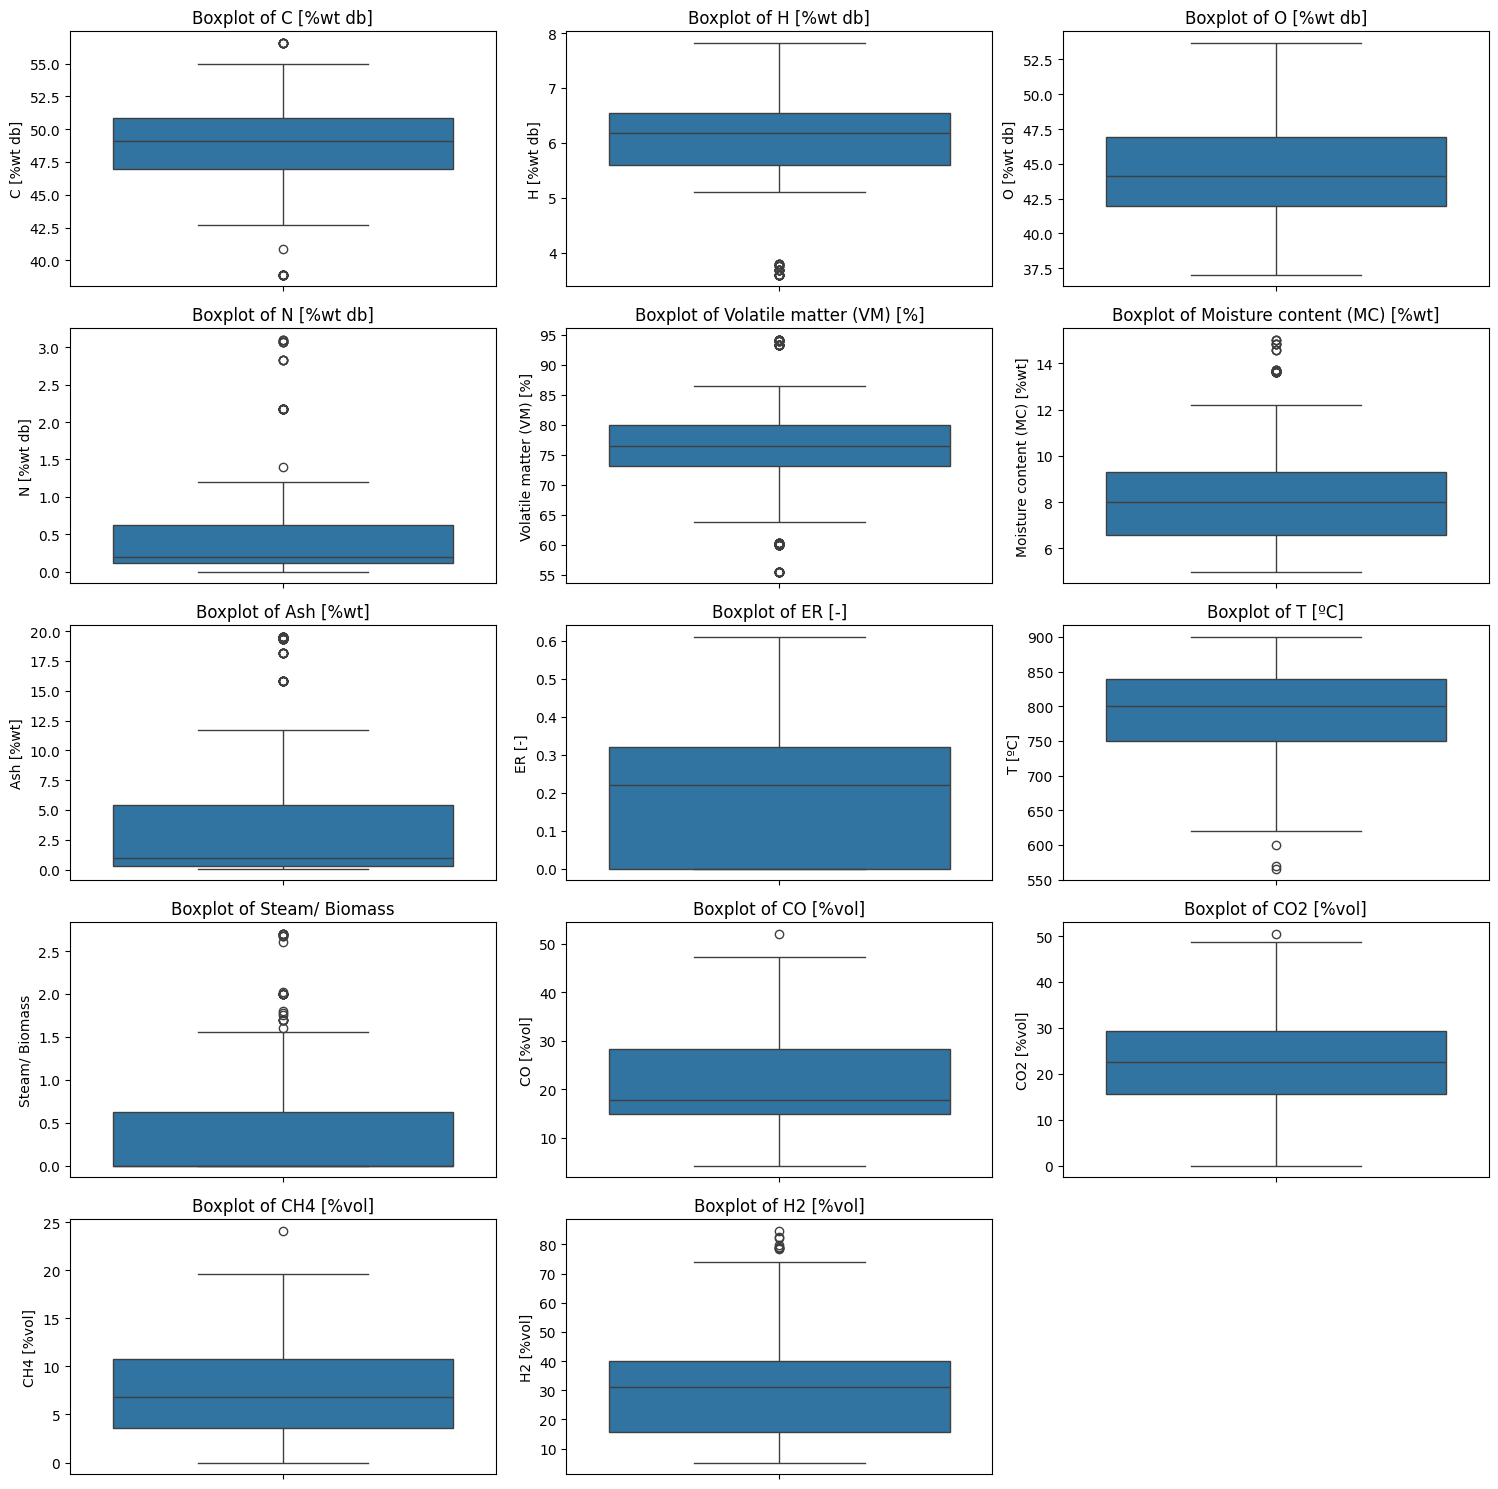

In [ ]:
# Define the number of columns per row of subplots
num_cols = 3
num_rows = int(np.ceil(len(df.columns) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
axes = axes.flatten()

# Create boxplots for each numeric column
for i, column in enumerate(df.columns):
    sns.boxplot(ax=axes[i], y=df[column])
    axes[i].set_title(f'Boxplot of {column}')

# Remove empty subplots if any are left over
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

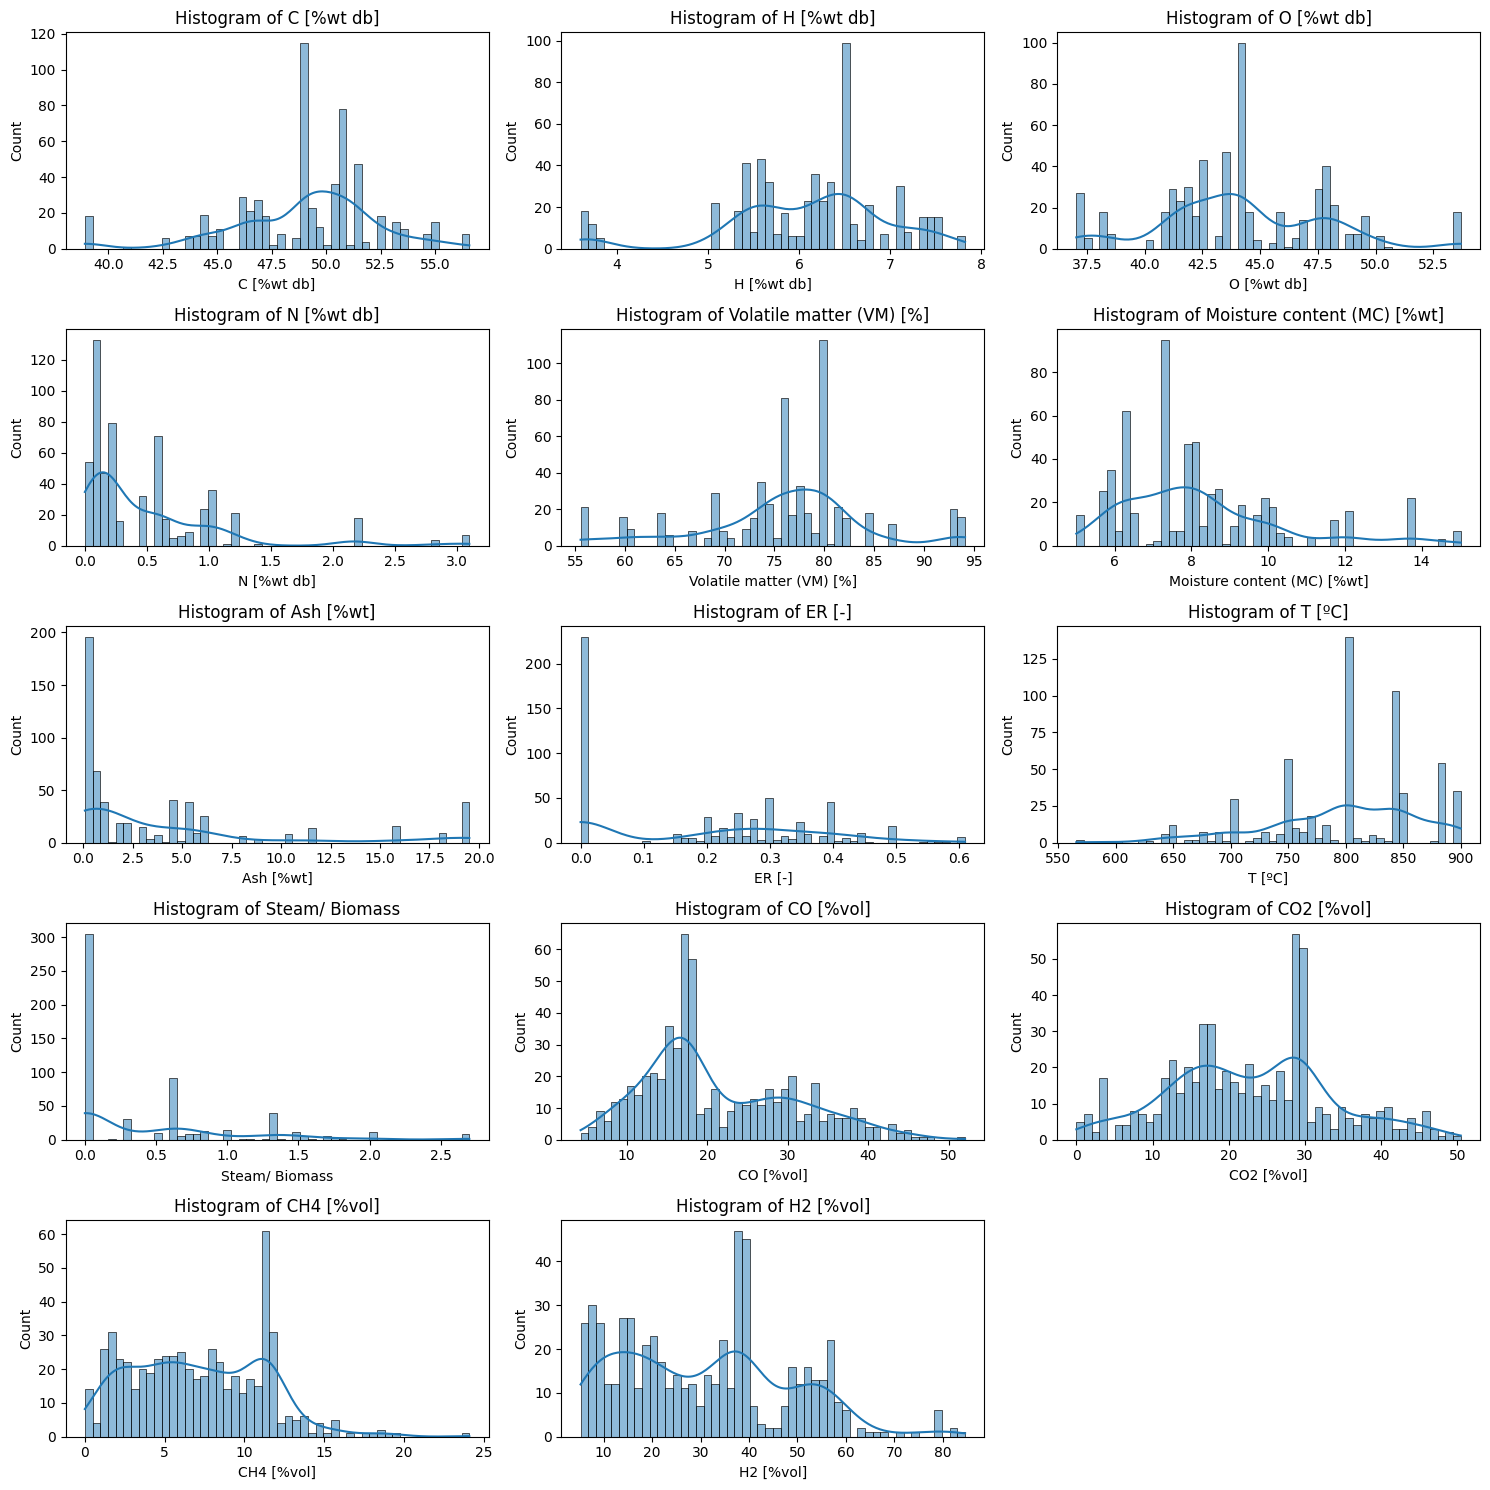

In [ ]:
# Define the number of columns per row of subplots
num_cols = 3
num_rows = int(np.ceil(len(df.columns) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
axes = axes.flatten()

# Create histograms for each numeric column
for i, column in enumerate(df.columns):
    sns.histplot(ax=axes[i], data=df, x=column, kde=True, bins=50)
    axes[i].set_title(f'Histogram of {column}')

# Remove empty subplots if any are left over
for i in range(len(df.columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

* The variables C, H, O, CO, and CO₂ show centered data with low dispersion and few outliers.
* The variables T, VM, and MC exhibit slight skewness and some outliers.
* The variables N, Ash, ER, S/B, CH₄, and H₂ show strong skewness and will require feature engineering.





   


### **Spearman Correlation**

Measures monotonic association, not necessarily linear.

It ranges from -1 to 1:

* +1: perfect positive correlation

* -1: perfect negative correlation

* 0: no monotonic association


|       Correlation Value    |       Interpretation       |
| ---------------------------: | ------------------------- |
|                  0.00 a 0.19 | Very weak / negligible |
|                  0.20 a 0.39 | Weak                     |
|                  0.40 a 0.59 | Moderate                |
|                  0.60 a 0.79 | Strong                    |
|                  0.80 a 1.00 | Very Strong               |


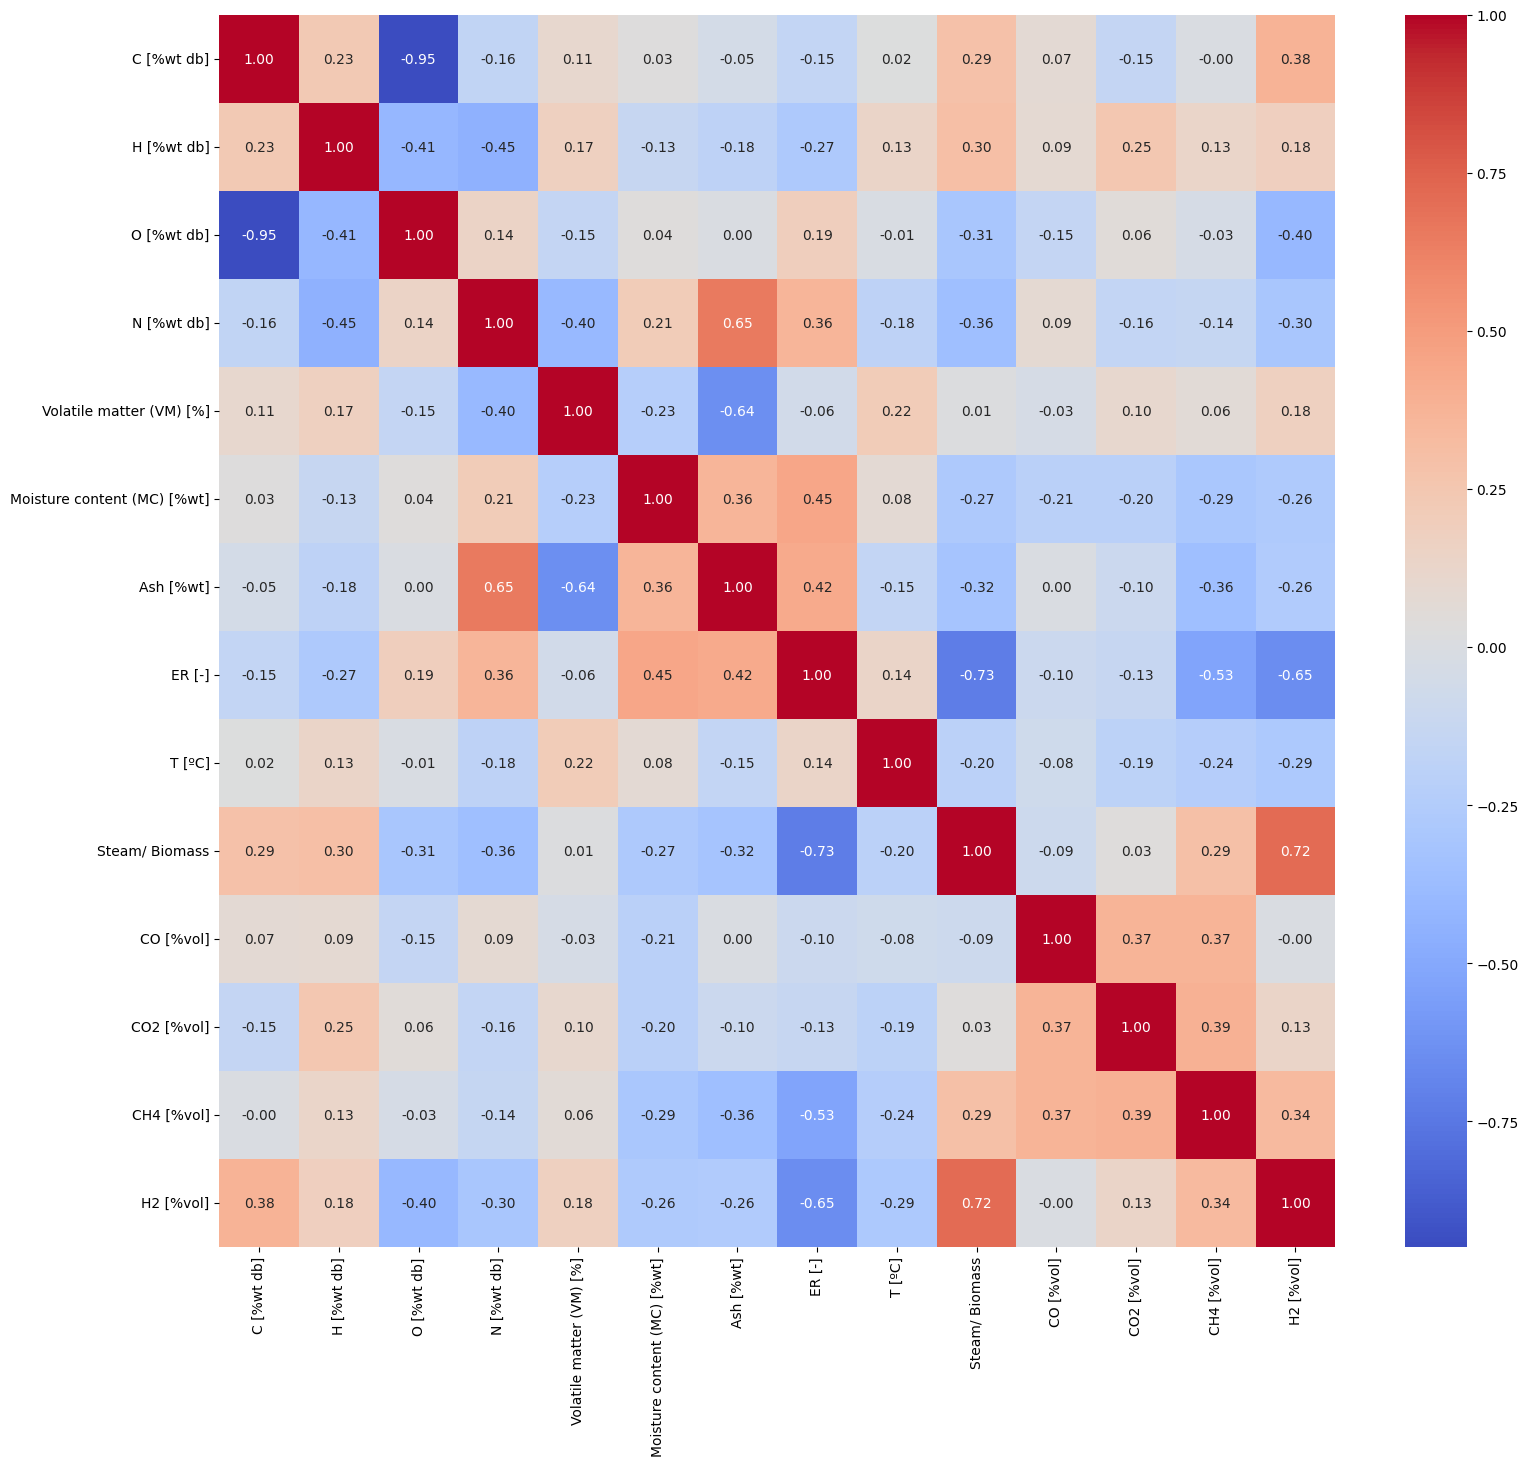

In [ ]:
# Create the Spearman Correlation
corr_S = df.iloc[:,:].corr(method='spearman')
plt.figure(figsize=(18, 16))
sns.heatmap(corr_S, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

In [ ]:
cols_input = ['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']
cols_output = ['C [%wt db]', 'H [%wt db]', 'O [%wt db]', 'N [%wt db]']
# Create a new DataFrame containing only the selected columns
df_subset = df[cols_input + cols_output]
# Compute the Spearman correlation for the data subset
corr_S_subset = df_subset.corr(method='spearman')
# Select only the correlations between input and output variables
corr_S_selected = corr_S_subset.loc[cols_input, cols_output]
# Print the correlation table in Markdown format
print(corr_S_selected.to_markdown())

|            |   C [%wt db] |   H [%wt db] |   O [%wt db] |   N [%wt db] |
|:-----------|-------------:|-------------:|-------------:|-------------:|
| CO [%vol]  |   0.0736445  |    0.0855207 |   -0.147393  |     0.0856   |
| CO2 [%vol] |  -0.147979   |    0.248132  |    0.0555292 |    -0.155661 |
| CH4 [%vol] |  -0.00417378 |    0.130553  |   -0.0310922 |    -0.138972 |
| H2 [%vol]  |   0.377975   |    0.182452  |   -0.400742  |    -0.303706 |


#### **Composition Variable Analysis: Output vs Input**

Carbon (C)

* C vs CO = +0.074 →
Slight positive correlation. This suggests that the carbon content in biomass does not strongly influence CO generation directly but may contribute indirectly through reactions with CO₂ (Boudouard reaction) or H₂O (water-gas shift).

* C vs CO₂ = −0.148 →
More carbon-rich biomasses tend to produce less CO₂. This supports the formation of CO via the Boudouard reaction rather than direct CO₂ emission.

* C vs CH₄ = −0.004 →
Essentially no correlation. The carbon content is not directly related to CH₄ formation.

* C vs H₂ = +0.378 →
Significant positive correlation. Higher carbon content increased Boudouard and water-gas reactions, so more hydrogen produced as a byproduct.

Hydrogen (H)

* H vs CO = +0.086 →
Slight positive correlation with no strong direct physical significance.

* H vs CO₂ = +0.248 →
Hydrogen-rich biomasses tend to produce more CO₂, possibly due to hydrogen oxidation into H₂O followed by water-gas shift reactions.

* H vs CH₄ = +0.131 →
Moderate correlation. A higher hydrogen presence favors CH₄ formation (methanation reaction).

* H vs H₂ = +0.182 →
Expected positive correlation, but weaker than anticipated. Suggests that H₂ formation may depend more on steam/biomass reactions than on the original hydrogen content.

Oxygen (O)

* O vs CO = −0.147 →
More oxygenated biomasses produce less CO, likely due to carbon being oxidized directly to CO₂.

* O vs CO₂ = +0.056 →
Weak positive correlation. Indicates a trend toward more CO₂ formation from oxygen-rich biomass (direct oxidation).

* O vs CH₄ = −0.031 →
Virtually no correlation. Oxygen content in biomass does not directly influence methane production.

* O vs H₂ = −0.401 →
Significant negative correlation. Higher oxygen content → lower H₂ production, possibly due to increased H₂O and CO₂ formation, which reduces free hydrogen yield.

Nitrogen (N)

* N vs CO = +0.086 →
Weak correlation with no direct technical or chemical significance.

* N vs CO₂ = −0.156 →
Suggests that nitrogen-rich biomass may oxidize less carbon into CO₂, or it may reflect indirect compositional effects.

* N vs CH₄ = −0.139 →
Slight negative impact. Nitrogen does not contribute to CH₄ formation and may indicate a lower proportion of volatile hydrocarbon-forming compounds.

* N vs H₂ = −0.304 →
Negative correlation. Nitrogen-rich biomass tends to produce less H₂, possibly because nitrogen does not participate in fuel gas generation and may structurally displace reactive components that would otherwise yield hydrogen.


In [ ]:
cols_input = ['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']
cols_output = ['Volatile matter (VM) [%]', 'Moisture content (MC) [%wt]', 'Ash [%wt]']
# Create a new DataFrame containing only the selected columns
df_subset = df[cols_input + cols_output]
# Compute the Spearman correlation for the data subset
corr_S_subset = df_subset.corr(method='spearman')
# Select only the correlations between input and output variables
corr_S_selected = corr_S_subset.loc[cols_input, cols_output]
# Print the correlation table in Markdown format
print(corr_S_selected.to_markdown())

|            |   Volatile matter (VM) [%] |   Moisture content (MC) [%wt] |    Ash [%wt] |
|:-----------|---------------------------:|------------------------------:|-------------:|
| CO [%vol]  |                 -0.0329171 |                     -0.2086   |  4.16585e-05 |
| CO2 [%vol] |                  0.102571  |                     -0.204344 | -0.0985575   |
| CH4 [%vol] |                  0.0617403 |                     -0.294114 | -0.360424    |
| H2 [%vol]  |                  0.17618   |                     -0.263531 | -0.25909     |


#### **Output vs Physicochemical Parameters**

* Volatile Matter (VM) shows a positive trend with H₂, indicating that biomass rich in volatiles may slightly contribute to increased hydrogen production. Overall impact is weak but still the most favorable among the three parameters.

* Moisture content has a consistently negative effect on all four gases. It primarily reduces CH₄ and H₂.

* Ash content is negatively correlated with the main combustible gases, especially CH₄. High ash levels impair the energy yield of the gasification process.




In [ ]:
cols_input = ['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']
cols_output = ['ER [-]', 'T [ºC]', 'Steam/ Biomass']
# Create a new DataFrame containing only the selected columns
df_subset = df[cols_input + cols_output]
# Compute the Spearman correlation for the data subset
corr_S_subset = df_subset.corr(method='spearman')
# Select only the correlations between input and output variables
corr_S_selected = corr_S_subset.loc[cols_input, cols_output]
# Print the correlation table in Markdown format
print(corr_S_selected.to_markdown())

|            |     ER [-] |     T [ºC] |   Steam/ Biomass |
|:-----------|-----------:|-----------:|-----------------:|
| CO [%vol]  | -0.0997952 | -0.0803417 |       -0.0889539 |
| CO2 [%vol] | -0.129747  | -0.194352  |        0.0339787 |
| CH4 [%vol] | -0.529288  | -0.239414  |        0.294168  |
| H2 [%vol]  | -0.646308  | -0.285396  |        0.717412  |


#### **Operational Parameters vs Produced Gas**

Steam/Biomass

* Steam/Biomass vs H₂ = +0.717 → Highly positive correlation, consistent with literature: higher steam levels favor the water-gas shift reaction, enhancing H₂ production.

* Steam/Biomass vs CH₄ = +0.294 → Steam also contributes to methanation, though to a lesser extent.

* Steam/Biomass vs CO/CO₂ ≈ weak → Limited direct impact on the formation of these gases.

Equivalence Ratio (ER)

* ER vs H₂ = -0.646 → Higher ER corresponds to lower H₂ levels, as increased oxygen promotes combustion over gasification, reducing the yield of combustible gases.

* ER vs CH₄ = -0.529 → Follows the same trend.

* ER vs CO₂ = slightly negative (-0.13) → Unexpected, as one might anticipate higher CO₂ levels due to oxidation of H₂ and CO; suggests possible secondary effects.

* ER vs Steam/Biomass = -0.725 → Logical, since steam can act as an alternative gasifying agent, reducing the need for O₂.

Temperature (T)

* T vs H₂ = -0.285, T vs CO = -0.080, both weak correlations → Unexpected, as temperature typically promotes H₂ and CO formation. This may indicate a narrow operational temperature range or indirect control via other parameters (e.g., ER or steam).

* T vs CH₄ = -0.239 → Expected: higher temperatures lead to CH₄ decomposition.


## **Principal Component Analysis (PCA)**

In [ ]:
# Create a PCA (Principal Component Analysis) object using the 'prince' library.
pca = prince.PCA(
    n_components=14,          # Number of principal components to keep.
    n_iter=3,                 # Number of iterations for the SVD solver (relevant when using some solvers).
    rescale_with_mean=True,   # Center the data before performing PCA (subtract the mean).
    rescale_with_std=True,    # Scale the data to unit variance (standardization).
    copy=True,                # Whether to perform the operation in-place or return a copy.
    check_input=True,         # Check input data for validity.
    engine='sklearn',         # Use scikit-learn's backend/engine for performing PCA.
    random_state=42           # Seed for reproducibility of results.
)

# Fit the PCA model to the DataFrame `df`.
# The method projects the dataset into a lower-dimensional space defined by the principal components.
pca = pca.fit(
    df,                         # The DataFrame containing input data to apply PCA on.
    sample_weight=None,         # Optional: weights for each row (sample). None means equal weights.
    column_weight=None,         # Optional: weights for each column (feature). None means equal weights.
    supplementary_columns=None  # Optional: columns that are supplementary and not used in computing components.
)

In [ ]:
# Displays a summary of the eigenvalues of the PCA
pca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,3.920,28.00%,28.00%
1,2.016,14.40%,42.40%
2,1.796,12.83%,55.23%
3,1.428,10.20%,65.43%
4,0.992,7.08%,72.51%
5,0.838,5.99%,78.50%
6,0.764,5.46%,83.96%
7,0.567,4.05%,88.01%
8,0.518,3.70%,91.71%


In [ ]:
# Shows how much each original variable (column) contributes to each principal component
# The `.style.format('{:.0%}')` formats the contributions as percentages with no decimal places
pca.column_contributions_.style.format('{:.0%}')

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13
variable,,,,,,,,,,,,,,
C [%wt db],12%,4%,7%,18%,4%,0%,0%,1%,6%,0%,2%,2%,0%,45%
H [%wt db],8%,1%,3%,5%,32%,1%,1%,10%,21%,6%,7%,2%,0%,4%
O [%wt db],12%,3%,5%,22%,0%,0%,3%,0%,2%,1%,0%,1%,0%,50%
N [%wt db],7%,4%,2%,0%,0%,29%,30%,19%,2%,1%,0%,1%,3%,2%
Volatile matter (VM) [%],4%,18%,8%,8%,3%,0%,11%,3%,1%,3%,0%,1%,38%,0%
Moisture content (MC) [%wt],6%,1%,12%,3%,13%,1%,14%,25%,10%,7%,6%,0%,2%,0%
Ash [%wt],9%,10%,8%,4%,12%,0%,0%,2%,4%,2%,0%,3%,44%,0%
ER [-],12%,7%,0%,6%,0%,9%,9%,0%,0%,0%,11%,41%,4%,0%
T [ºC],1%,17%,2%,0%,10%,28%,27%,0%,8%,2%,0%,5%,0%,0%


In [ ]:
# Displays the correlations between the original variables (columns) and the principal components.
pca.column_correlations

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13
variable,,,,,,,,,,,,,,
C [%wt db],-0.676433,0.273778,0.344192,0.506991,0.209212,-0.013524,0.019924,-0.067496,-0.173807,-0.049041,-0.075683,0.063781,0.006088,-0.024960
H [%wt db],-0.545816,0.162820,-0.235658,0.266635,-0.560083,-0.081456,0.089903,0.234995,0.330901,-0.179199,0.140642,-0.061526,-0.009510,-0.007013
O [%wt db],0.699650,-0.243546,-0.308349,-0.559772,-0.019909,-0.050354,-0.141302,-0.051786,0.101058,0.056875,0.025826,-0.047361,-0.010717,-0.026430
N [%wt db],0.535661,-0.270678,0.167208,0.071445,-0.042642,0.494633,0.481987,0.325892,-0.098987,0.071343,0.018626,0.043939,-0.067465,-0.004734
Volatile matter (VM) [%],-0.402590,0.596406,-0.386895,-0.347283,0.169717,0.028124,0.285005,0.134740,-0.083609,0.131336,0.037211,-0.043575,0.235428,-0.000955
Moisture content (MC) [%wt],0.468247,0.160240,0.472240,0.216926,0.355535,-0.095131,-0.321523,0.376195,0.223484,0.181958,0.132903,-0.024666,0.057621,-0.000057
Ash [%wt],0.597055,-0.439453,0.381028,0.251884,-0.351490,-0.022922,-0.010894,-0.118703,-0.144755,-0.105598,0.029351,-0.083153,0.252225,-0.001193
ER [-],0.697173,0.383741,-0.073657,0.284185,0.066536,-0.278991,0.255539,-0.018895,0.001242,0.018150,-0.176420,-0.309339,-0.073755,0.000197
T [ºC],0.144202,0.582198,-0.164396,0.082354,-0.317433,0.486282,-0.453799,0.022198,-0.203173,0.093920,-0.034491,-0.103908,-0.026373,0.000071


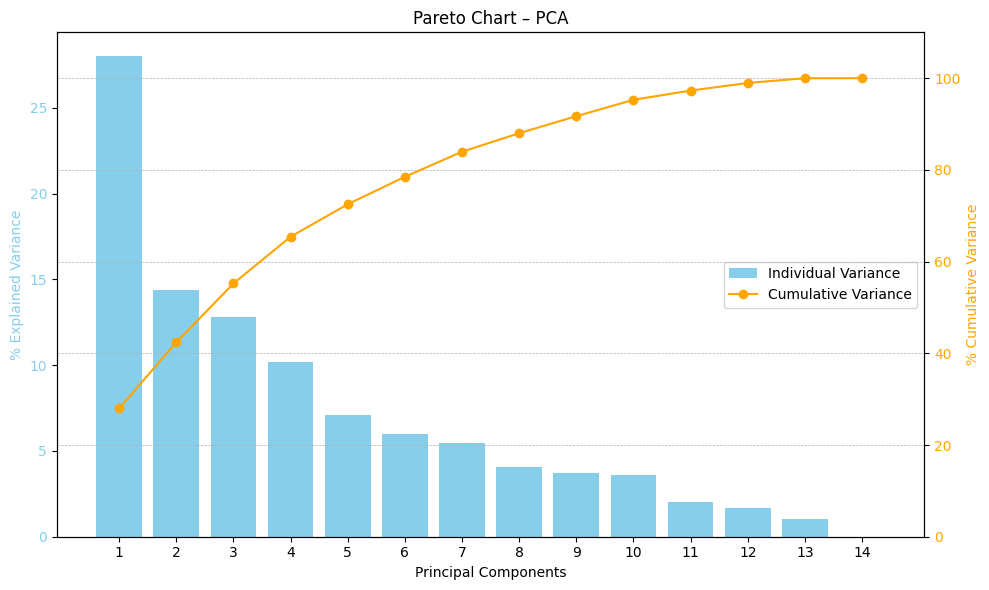

In [ ]:
eigen_df = pca.eigenvalues_summary

# Extract data
eigenvalues = eigen_df['eigenvalue'].values
variance = eigen_df['% of variance'].str.replace('%', '').astype(float).values
cumulative = eigen_df['% of variance (cumulative)'].str.replace('%', '').astype(float).values

# Plot the Pareto chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bars: Individual Variance
ax1.bar(range(1, len(variance) + 1), variance, color='skyblue', label='Individual Variance')
ax1.set_xlabel('Principal Components')
ax1.set_ylabel('% Explained Variance', color='skyblue')
ax1.set_xticks(np.arange(1, len(variance) + 1))
ax1.tick_params(axis='y', labelcolor='skyblue')

# Line: Cumulative Variance
ax2 = ax1.twinx()
ax2.plot(range(1, len(cumulative) + 1), cumulative, color='orange', marker='o', label='Cumulative Variance')
ax2.set_ylabel('% Cumulative Variance', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 110)

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center right')

plt.title('Pareto Chart – PCA')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Based on the Pareto chart from the Principal Component Analysis (PCA), it is observed that the first four principal components account for approximately 65% of the total data variance. When the first nine components are considered, the explained variance reaches around 90%, a threshold commonly used as a cutoff criterion for component retention in multivariate analyses.

<Figure size 1200x600 with 0 Axes>

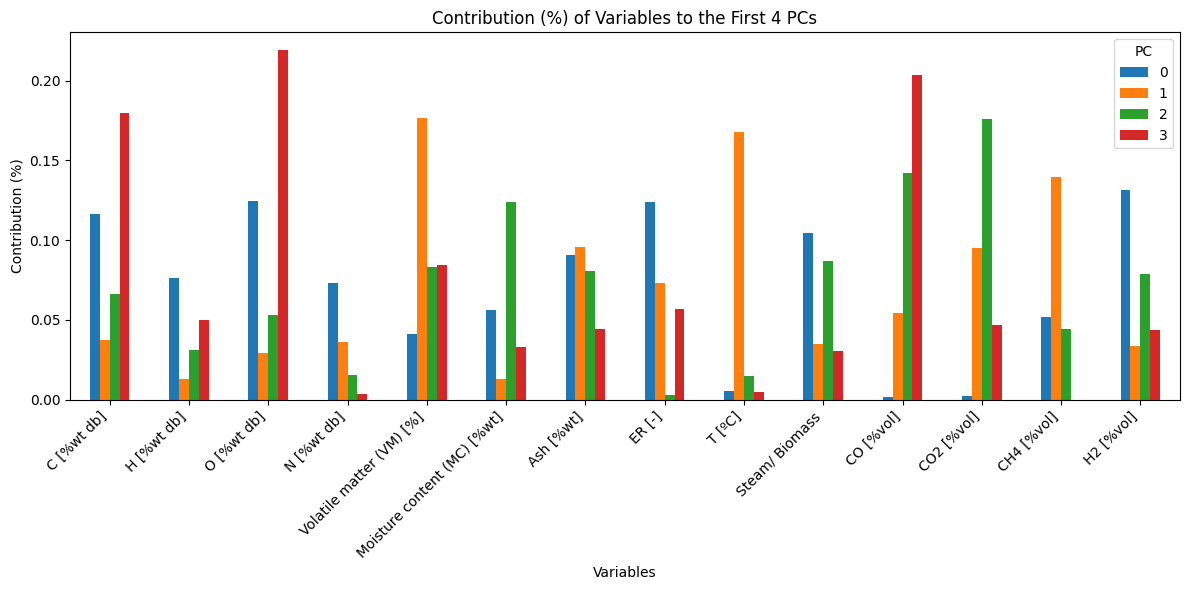

In [ ]:
# Chart: Contribution of Variables to the First Four Principal Components
contributions = pca.column_contributions_
plt.figure(figsize=(12,6))
contributions.iloc[:, :4].plot(kind='bar', figsize=(12,6))
plt.title('Contribution (%) of Variables to the First 4 PCs')
plt.ylabel('Contribution (%)')
plt.xlabel('Variables')
plt.xticks(rotation=45, ha='right')
plt.legend(title='PC')
plt.tight_layout()
plt.show()

Based on the presented chart, it is evident that the input variables related to the elemental composition of the biomass exert a strong influence on the first four principal components, which together explain approximately 65% of the total data variance. Among the physicochemical parameters, volatile matter (VM) stands out as the most relevant, while among the operational variables, the steam-to-biomass ratio (S/B) emerges as the most influential across all four components. This analysis aligns with the results obtained from the correlation assessment, reinforcing the indication that carbon (C), oxygen (O), volatile matter (VM), and the S/B ratio are the most significant contributors to data variability and are, therefore, potentially the most relevant variables for modeling the gasification process.



# **Data Split into Training, Testing, and Validation Sets**


In [ ]:
# Define the input (X) and output (y) columns
X = df.drop(columns=['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]'])
y = df[['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']]

# First split: separate 18.57% for validation and the remaining (81.43%) for training + testing
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.1857, random_state=42)

# Second split: separate training (65.17% of the original total, which is approximately 80% of temp) and testing (16.25% of the original total, approx. 20% of temp)
# We calculate the training proportion relative to the temporary (train+test) set:
# training_proportion_in_temp = 0.6517 / (1 - 0.1857) ≈ 0.7999
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)  # We use 20% of the temp set for testing, leaving 80% for training

# Check the sizes of each dataset
print(f'Training set size: {X_train.shape[0]} ({X_train.shape[0]/df.shape[0]:.2%})')
print(f'Test set size: {X_test.shape[0]} ({X_test.shape[0]/df.shape[0]:.2%})')
print(f'Validation set size: {X_val.shape[0]} ({X_val.shape[0]/df.shape[0]:.2%})')

# Proportion calculations:
# Total samples: 581
# Validation: 18.57% of 581 ≈ 107.8 -> 108 samples. test_size=0.1857 results in 108 samples.
# Remaining (temp): 581 - 108 = 473 samples
# Training: 65.17% of 581 ≈ 378.6 -> 379 samples
# Test: 16.25% of 581 ≈ 94.4 -> 94 samples
# 379 + 94 + 108 = 581

# Proportion of the test set within the temp set (473 samples):
# 94 / 473 ≈ 0.1987 ≈ 0.20 (20%)


Training set size: 378 (65.06%)
Test set size: 95 (16.35%)
Validation set size: 108 (18.59%)


#**SMOGN**

As observed in the descriptive statistical analyses (statistical summary, boxplot, and histogram), the dataset exhibits high variability and class imbalance. To address this issue, the SMOGN method (Synthetic Minority Over-sampling Technique for Regression with Gaussian Noise) was applied to balance the distribution of rare target variables related to the syngas composition produced during biomass gasification. Additionally, all data were normalized to ensure scale uniformity across variables.

In the apply_smogn_multitarget function, the following key parameters were defined:

* rel_thres: Sets the relative threshold to identify rare samples.

* k: Number of neighbors used in the interpolation process for synthetic data generation.

* rel_method = "auto": Automatic method for defining rarity criteria based on the individual distributions of each target variable.

* under_smpl = False: Undersampling was not applied, thereby preserving the original distribution of the majority classes.

In [ ]:
def apply_smogn_multitarget(df, targets, max_frac=0.4, rel_thres=0.9, k=2, random_state=42, rel_ctrl_pts_rg=None):
    """
    Applies SMOGN for multi-target (multi-output) regression data balancing.

    Parameters:
        df: DataFrame with the original data.
        targets: List of target (output) variables to be balanced.
        max_frac: Maximum fraction of synthetic samples relative to the original size.
        rel_thres: Relevance threshold for automatic SMOGN relevance function.
        k: Number of neighbors used by SMOGN.
        rel_ctrl_pts_rg: Control points for a custom (manual) relevance function (optional).

    Returns:
        Balanced DataFrame with original + synthetic samples.
    """

    # Select only numerical columns to avoid issues with SMOGN
    df_num = df.select_dtypes(include='number').copy()

    # Validate that all target variables exist and are numeric
    for target in targets:
        if target not in df_num.columns:
            raise ValueError(f"Target variable '{target}' is not in the DataFrame or is not numeric.")

    n_original = len(df)
    max_rows = int(n_original * (1 + max_frac))  # Maximum total rows allowed after balancing
    synthetic_dfs = []  # List to hold synthetic dataframes for each target

    # Scale the data using RobustScaler to reduce the influence of outliers
    scaler = RobustScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns=df_num.columns)

    generated_per_target = {target: 0 for target in targets}  # Track how many samples are generated per target

    # Apply SMOGN separately for each target variable
    for y in targets:
        try:
            # Base parameters for SMOGN
            smogn_params = {
                'data': df_scaled,
                'y': y,
                'k': k,
                'samp_method': 'balance',
                'drop_na_col': True,
                'drop_na_row': True,
                'replace': False,
                'pert': 0.04  # Amount of perturbation in SMOGN
            }

            # Use manual relevance for CO2 if control points are provided, otherwise use automatic
            if y == 'CO2 [%vol]' and rel_ctrl_pts_rg is not None:
                smogn_params.update({
                    'rel_method': 'manual',
                    'rel_ctrl_pts_rg': rel_ctrl_pts_rg
                })
            else:
                smogn_params.update({
                    'rel_method': 'auto',
                    'rel_thres': rel_thres
                })

            # Generate synthetic data for the current target
            df_synth = smogn.smoter(**smogn_params)

            # Identify newly generated synthetic samples (exclude duplicates of original data)
            df_synth_tuples = df_synth.apply(tuple, axis=1)
            df_scaled_tuples = df_scaled.apply(tuple, axis=1)
            new_samples_mask = ~df_synth_tuples.isin(df_scaled_tuples)
            df_extra_scaled = df_synth[new_samples_mask].dropna().drop_duplicates()

            # Inverse scale the synthetic samples back to original scale
            if not df_extra_scaled.empty:
                df_extra = pd.DataFrame(
                    scaler.inverse_transform(df_extra_scaled),
                    columns=df_num.columns
                ).drop_duplicates()

                generated_per_target[y] = len(df_extra)
                synthetic_dfs.append(df_extra)

        except Exception as e:
            continue  # If an error occurs for one target, skip it and continue

    # If no synthetic samples were created, return the original numeric DataFrame
    if not synthetic_dfs:
        print("\n❌ No synthetic samples generated.")
        return df_num

    # Combine all synthetic samples
    df_synthetic = pd.concat(synthetic_dfs, ignore_index=True).drop_duplicates()
    num_synthetic_needed = max_rows - n_original

    # Trim or accept all synthetic samples depending on the max allowed
    if len(df_synthetic) > num_synthetic_needed and num_synthetic_needed > 0:
        df_synthetic_final = df_synthetic.sample(n=num_synthetic_needed, random_state=random_state)
    elif num_synthetic_needed <= 0:
        df_synthetic_final = pd.DataFrame(columns=df_num.columns)
    else:
        df_synthetic_final = df_synthetic

    # Combine original and final synthetic samples
    final_df = pd.concat([df_num, df_synthetic_final], ignore_index=True)

    # ✅ Simplified final report: total number of synthetic samples
    total_synthetic = len(df_synthetic_final)
    print(f"\n✅ Total synthetic samples generated: {total_synthetic}")

    return final_df

In [ ]:
# Combine training features (X_train) and targets (y_train) into a single DataFrame.
# This is needed because SMOGN expects a single DataFrame input.
df_train = pd.concat([X_train, y_train], axis=1)

# Define the list of target variables to balance using SMOGN
targets = ['CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']

# Define manual relevance control points for the SMOGN algorithm.
# Each sublist follows the format: [value, relevance, slope]
# This tells SMOGN how important different ranges of the target are (e.g., above 20 is considered "important").
rel_ctrl_pts_rg = [
    [0.0, 0, 0],   # Value 0: relevance 0 (not important)
    [10.0, 0, 0],  # Value 10: still not important
    [20.0, 1, 0],  # Value 20: starts being fully relevant
    [50.0, 1, 0]   # Value 50: fully relevant
]

# Apply the SMOGN-based balancing function to the training data.
# This will generate synthetic samples to better represent underrepresented areas of the target distributions.
df_train_balanced = apply_smogn_multitarget(
    df=df_train,
    targets=targets,
    max_frac=0.4,          # Allow up to 40% more samples than the original dataset
    rel_thres=0.8,         # Threshold used for automatic relevance (not used for CO2 due to manual method)
    k=3,                   # Number of neighbors used in SMOGN
    rel_ctrl_pts_rg=rel_ctrl_pts_rg,  # Apply manual relevance to CO2
    random_state=42        # Set random seed for reproducibility
)

# Separate the balanced DataFrame back into input features and target outputs
X_train_balanced = df_train_balanced.drop(columns=targets)
y_train_balanced = df_train_balanced[targets]

# Print the shapes of the balanced training sets to confirm the result
print(f"\n✅ X_train_balanced: {X_train_balanced.shape}")
print(f"✅ y_train_balanced: {y_train_balanced.shape}")

# Save the balanced input features (X_train_balanced) to an Excel file.
with pd.ExcelWriter("X_train_balanced.xlsx") as writer:
    X_train_balanced.to_excel(writer)  # Write the DataFrame to the Excel file
    print("\n✅ X_train_balanced.xlsx saved.")  # Confirm that the file has been saved

# Save the balanced target outputs (y_train_balanced) to a separate Excel file.
with pd.ExcelWriter("y_train_balanced.xlsx") as writer:
    y_train_balanced.to_excel(writer)  # Write the DataFrame to the Excel file
    print("✅ y_train_balanced.xlsx saved.")  # Confirm that the file has been saved

synth_matrix: 100%|##########| 9/9 [00:00<00:00, 29.80it/s]



✅ Total synthetic samples generated: 151

✅ X_train_balanced: (529, 10)
✅ y_train_balanced: (529, 4)

✅ X_train_balanced.xlsx saved.
✅ y_train_balanced.xlsx saved.


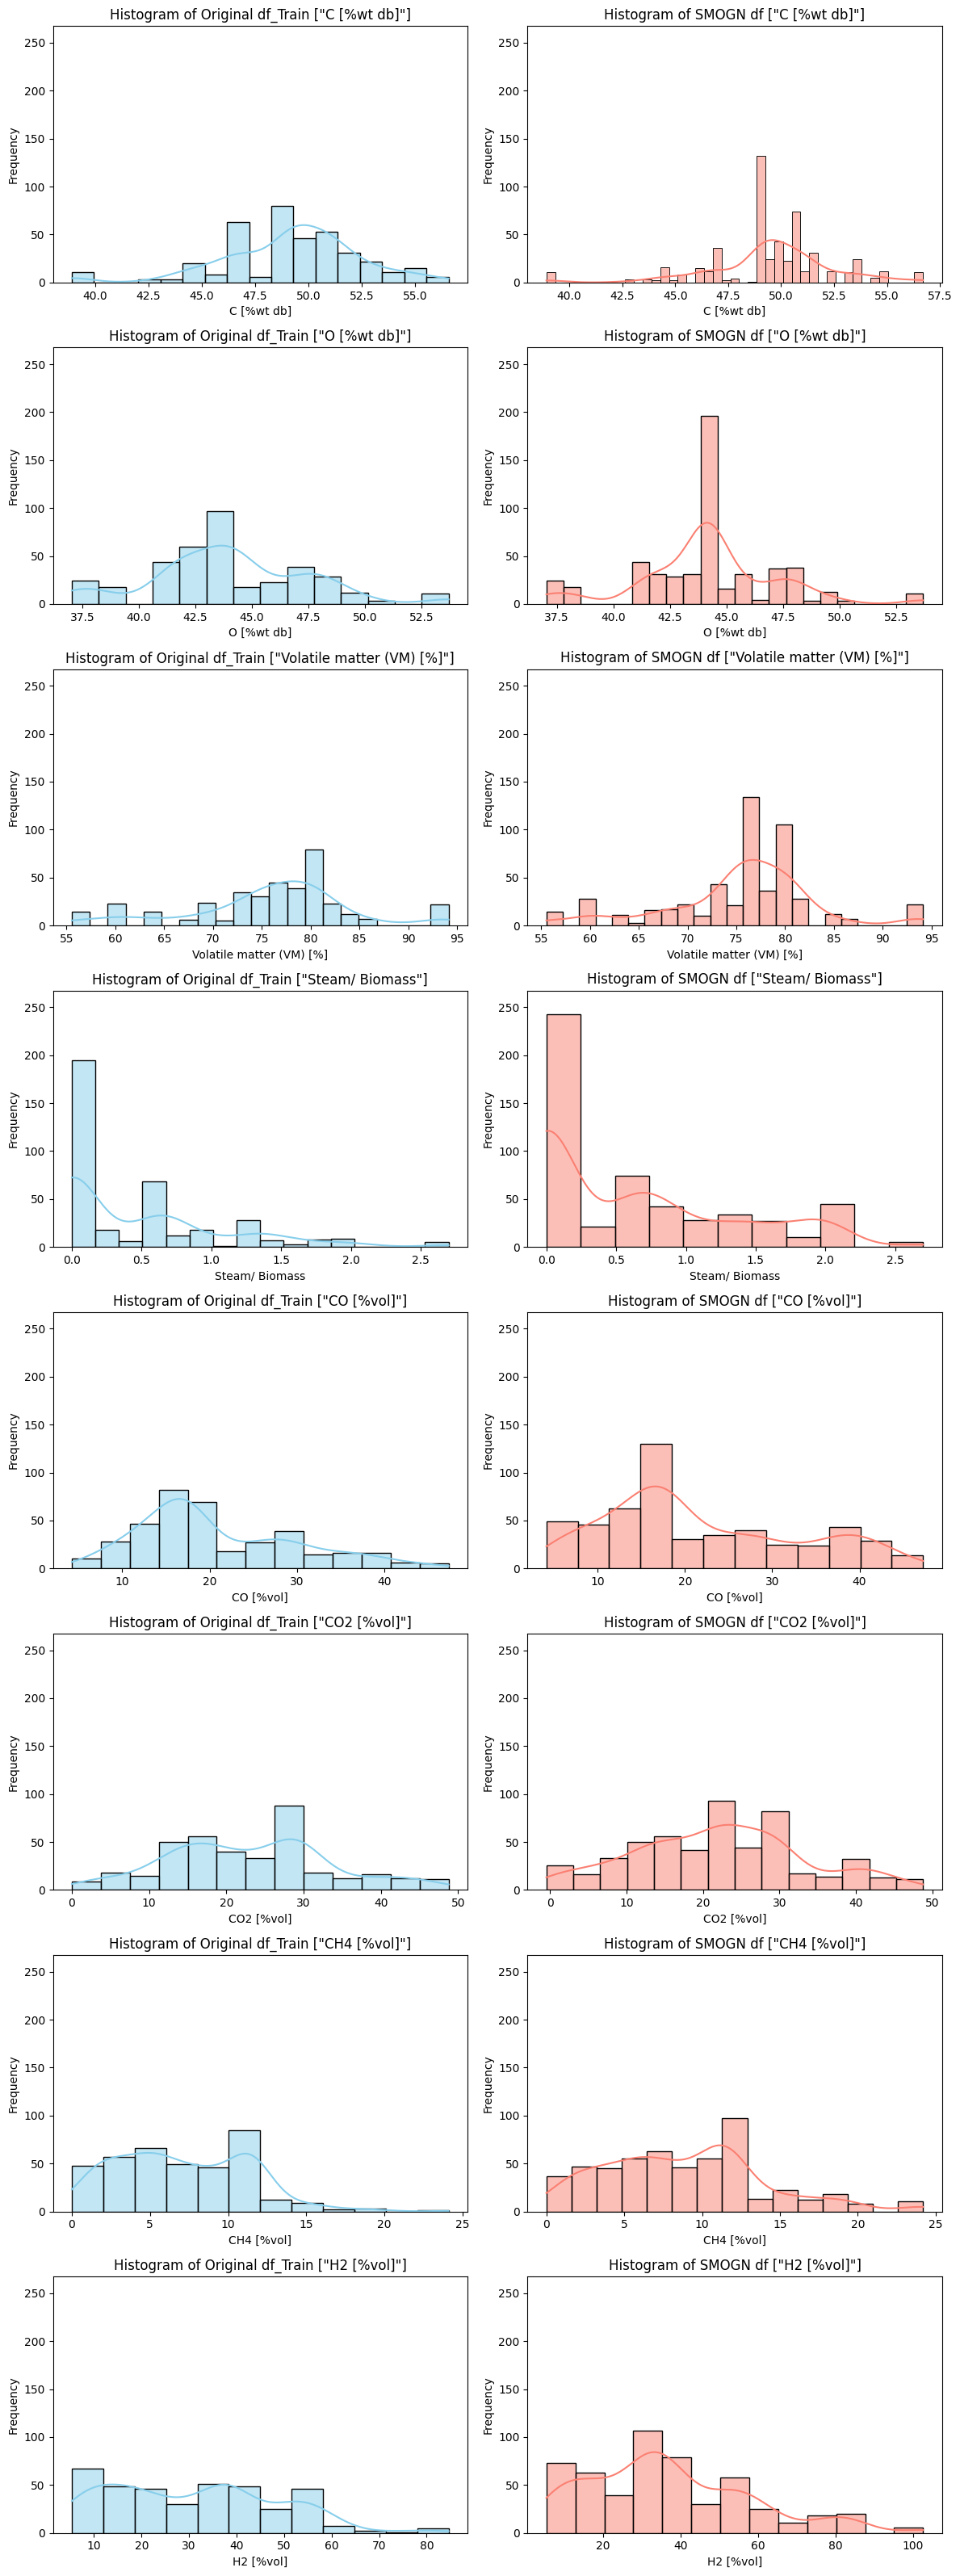

In [ ]:
# Lists with column names
columns = ['C [%wt db]',  'O [%wt db]', 'Volatile matter (VM) [%]',
           'Steam/ Biomass', 'CO [%vol]', 'CO2 [%vol]', 'CH4 [%vol]', 'H2 [%vol]']

# Number of pairs
num_pairs = len(columns)

# General figure size
fig, axes = plt.subplots(nrows=num_pairs, ncols=2, figsize=(12, 4 * num_pairs))

# Ensure a 2D array
axes = axes.reshape((num_pairs, 2))

# Find the maximum value for the Y-axis in both dataframes
y_max_overall = 0
for col in columns:
    if col in df_train.columns:
      hist_original, _ = np.histogram(df_train[col].dropna(), bins='auto')
      y_max_original = max(hist_original) if len(hist_original) > 0 else 0
    else:
      y_max_original = 0
    if col in df_train_balanced.columns:
      hist_balanced, _ = np.histogram(df_train_balanced[col].dropna(), bins='auto')
      y_max_balanced = max(hist_balanced) if len(hist_balanced) > 0 else 0
    else:
      y_max_balanced = 0
    y_max_overall = max(y_max_overall, y_max_original, y_max_balanced)

# Generate histograms
for i, col in enumerate(columns):
    # Histogram of the original df
    sns.histplot(df_train[col], ax=axes[i][0], kde=True, color='skyblue')
    axes[i][0].set_title(f'Histogram of Original df_Train ["{col}"]') # Translated title
    axes[i][0].set_xlabel(col) # Translated xlabel
    axes[i][0].set_ylabel('Frequency') # Translated ylabel
    axes[i][0].set_ylim(0, y_max_overall * 1.1) # Set Y limit based on overall max
    # Histogram of the balanced df (SMOGN)
    sns.histplot(df_train_balanced[col], ax=axes[i][1], kde=True, color='salmon')
    axes[i][1].set_title(f'Histogram of SMOGN df ["{col}"]') # Translated title
    axes[i][1].set_xlabel(col) # Translated xlabel
    axes[i][1].set_ylabel('Frequency') # Translated ylabel
    axes[i][1].set_ylim(0, y_max_overall * 1.1) # Set Y limit based on overall max

# Adjusted layout
plt.tight_layout()
plt.show()

SMOGN generated a total of 151 new synthetic samples. Upon analyzing the resulting histograms, a significant shift was observed in the distribution of the target variables. The original distributions, which previously exhibited more concentrated value ranges, were smoothed, with increased data presence in both central regions and distribution tails. This indicates that the balancing process aimed not only to reinforce the central regions but also to enhance the representation of samples in low-density areas, contributing to a more uniform coverage of the sample space and mitigating the original imbalance.
